In [1]:
import numpy as np
import pandas as pd
import re

import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
import collections 

from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from collections import namedtuple
from scipy import spatial
import math

In [2]:
from sklearn.preprocessing import scale, robust_scale, minmax_scale, maxabs_scale

In [3]:
d2v_model = Doc2Vec.load('../model/word_embedding/Doc2vec_new_small2_4.model')

# modeling

### 데이터셋 불러오기

In [4]:
final_list  = pd.read_excel('./new_data/final_list_score2.xlsx')

In [5]:
final_list.isnull().sum()

company                    0
token                      0
predicted_label1           1
predicted_label2           3
predicted_small_label1     1
predicted_small_label2     0
invest                    17
establish                  2
establish2                 0
dtype: int64

In [6]:
final_list.fillna('nan', inplace=True)

In [7]:
final_list['invest'] = final_list['invest'].apply(lambda x: re.sub(' ', '', str(x)))

In [8]:
final_list['invest'] = [str(x).split(',') for x in final_list['invest']]

### 네트워크

In [9]:
def network_score(G) :
    tt =  { "degree":dict(G.degree()), 
            "degree_centrality":nx.degree_centrality(G), #normalized degree, degree가 클수록 높음
            "closeness_centrality":nx.closeness_centrality(G), 
            "betweenness_centrality":nx.betweenness_centrality(G), 
            "pagerank":nx.pagerank(G)}
    tt_df = pd.DataFrame(tt)
    tt_df['node'] = list(tt_df.index)
    tt_df = pd.merge(tt_df,node_df,how='left')
    return tt_df

In [20]:
company = list(final_list['company'])
company_idx = ["c%d" % i for i in range(1,len(company)+1)]
node_df = pd.DataFrame({'node':company,'node_idx':company_idx})

In [21]:
node_df.head()

,node,node_idx
0,데일리금융그룹,c1
1,비바 리퍼블리카,c2
2,밸런스히어로,c3
3,샌드박스 네트워크,c4
4,테라,c5


In [22]:
invest = []
for inv in list(final_list['invest']):
    temp = [str(txt).strip() for txt in inv]
    invest.append(temp)

In [23]:
temp = []
for i in range(len(invest)):
    temp  = temp + invest[i]

In [24]:
invest = list(set(temp))
invest_idx = ["i%d" % i for i in range(1,len(invest)+1)]

In [25]:
invest_node = pd.DataFrame({'node':invest,'node_idx':invest_idx})
node_df = node_df.append(pd.DataFrame(data=invest_node),ignore_index=True)

In [26]:
edge = []
weigth_edge = []
# weight_list = []
for i in range(len(final_list)):
    weight_sum = 0 
    for j in range(len(final_list['invest'][i])):
        if final_list['invest'][i][j] != 'nan':
            company = final_list['company'][i]
            invest = final_list['invest'][i][j]
            edge.append((invest,company))

In [27]:
small = list(set(list(final_list['predicted_small_label1']) + list(final_list['predicted_small_label2'])))
small_idx = ["s%d" % i for i in range(1,len(small)+1)]

In [28]:
small_node = pd.DataFrame({'node':small,'node_idx':small_idx})
node_df = node_df.append(pd.DataFrame(data=small_node),ignore_index=True)

In [29]:
s_edge = []
for i in range(len(final_list)):
    company = final_list['company'][i]
    small1 = final_list['predicted_small_label1'][i]
    if small1 == 'nan':
        print(company)
    else:
        s_edge.append((small1,company))
    small2 = final_list['predicted_small_label2'][i]
    if small2 == 'nan':
        print(company)
    else:
        s_edge.append((small2,company))

설리번 프로젝트


In [30]:
nondirect_G = nx.Graph()
nondirect_G.add_edges_from(edge+s_edge)
nondirect_score = network_score(nondirect_G)

In [31]:
nondirect_score.to_excel('network_score.xlsx', index=False, encoding='cp949')

In [32]:
company_network_result = nondirect_score[nondirect_score['node_idx'].isin(company_idx)].sort_values(["pagerank"], ascending=[False])

In [33]:
company_tech = final_list[['company','predicted_label1','predicted_label2']]

In [41]:
company_tech.rename(columns={'company':'node'}, inplace=True)

C:\Users\lmhoon012\Anaconda3\lib\site-packages\pandas\core\frame.py:4301: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [42]:
company_network_result['total_weight'] = company_network_result[['closeness_centrality','betweenness_centrality', 'pagerank']].sum(axis=1)
company_network_result = company_network_result.sort_values(["total_weight"], ascending=[False]).reset_index(drop=True)

In [43]:
company_network_result

,degree,degree_centrality,closeness_centrality,betweenness_centrality,pagerank,node,node_idx,total_weight,predicted_label1,predicted_label2
0,13,0.038576,0.246706,0.106267,0.011985,밸런스히어로,c3,0.364958,핀테크,AI/빅데이터
1,14,0.041543,0.229564,0.096629,0.014899,(주)뤼이드,c10,0.341092,서비스플랫폼,AI/빅데이터
2,8,0.023739,0.239007,0.088405,0.007110,클래스101,c41,0.334522,서비스플랫폼,AI/빅데이터
3,10,0.029674,0.230191,0.067742,0.010153,패스트캠퍼스,c24,0.308086,AI/빅데이터,서비스플랫폼
4,7,0.020772,0.234353,0.052951,0.006826,수아랩,c13,0.294130,스마트팩토리,AI/빅데이터
...,...,...,...,...,...,...,...,...,...,...
91,2,0.005935,0.170374,0.003137,0.002392,메디픽셀,c94,0.175904,AI/빅데이터,O2O/지식서비스
92,4,0.011869,0.145134,0.017751,0.005836,아모랩,c95,0.168721,바이오/헬스케어,디지털콘텐츠디자인
93,3,0.008902,0.142314,0.009689,0.003646,부스트,c44,0.155649,스마트팩토리,블록체인
94,2,0.005935,0.130116,0.005103,0.002539,스테이지랩스,c78,0.137758,블록체인,O2O/지식서비스


In [44]:
company_network_result = pd.merge(company_network_result, company_tech)

In [45]:
company_network_result

,degree,degree_centrality,closeness_centrality,betweenness_centrality,pagerank,node,node_idx,total_weight,predicted_label1,predicted_label2
0,13,0.038576,0.246706,0.106267,0.011985,밸런스히어로,c3,0.364958,핀테크,AI/빅데이터
1,14,0.041543,0.229564,0.096629,0.014899,(주)뤼이드,c10,0.341092,서비스플랫폼,AI/빅데이터
2,8,0.023739,0.239007,0.088405,0.007110,클래스101,c41,0.334522,서비스플랫폼,AI/빅데이터
3,10,0.029674,0.230191,0.067742,0.010153,패스트캠퍼스,c24,0.308086,AI/빅데이터,서비스플랫폼
4,7,0.020772,0.234353,0.052951,0.006826,수아랩,c13,0.294130,스마트팩토리,AI/빅데이터
...,...,...,...,...,...,...,...,...,...,...
91,2,0.005935,0.170374,0.003137,0.002392,메디픽셀,c94,0.175904,AI/빅데이터,O2O/지식서비스
92,4,0.011869,0.145134,0.017751,0.005836,아모랩,c95,0.168721,바이오/헬스케어,디지털콘텐츠디자인
93,3,0.008902,0.142314,0.009689,0.003646,부스트,c44,0.155649,스마트팩토리,블록체인
94,2,0.005935,0.130116,0.005103,0.002539,스테이지랩스,c78,0.137758,블록체인,O2O/지식서비스


In [33]:
company_network_result.to_excel('./new_data/company_network_result.xlsx', index=False, encoding='cp949')

In [34]:
# bio_health = company_network_result[(company_network_result['predicted_label1']=='바이오/헬스케어') | (company_network_result['predicted_label2']=='바이오/헬스케어')]

In [35]:
# bio_health.to_excel('./new_data/bio_health.xlsx', index=False, encoding='cp949')

In [53]:
bio_health = pd.read_excel('./new_data/bio_health.xlsx')

In [62]:
bio_health = bio_health[bio_health['status'] == 1]

In [66]:
bio_health[['total_weight', 'invest_total', 'invest_num']].corr().to_excel('corr.xlsx')

In [36]:
tech_network_result = nondirect_score[nondirect_score['node_idx'].isin(small_idx)].sort_values(["pagerank"], ascending=[False])

In [37]:
tech_network_result['total_weight'] = tech_network_result[['closeness_centrality','betweenness_centrality', 'pagerank']].sum(axis=1)
tech_network_result = tech_network_result.sort_values(["total_weight"], ascending=[False]).reset_index(drop=True)

In [38]:
tech_network_result.to_excel('./new_data/tech_network_result.xlsx', index=False, encoding='cp949')

### 네트워크 그리키

In [39]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

# Input data files check
from subprocess import check_output

import warnings
warnings.filterwarnings('ignore')

In [40]:
edge = []
for i in range(len(final_list)):
    weight_sum = 0 
    for j in range(len(final_list['invest'][i])):
        if final_list['invest'][i][j] != 'nan':
            company = final_list['company'][i]
            invest = final_list['invest'][i][j]
            company = node_df[node_df['node']==company]['node_idx'].values[0]
            invest = node_df[node_df['node']==invest]['node_idx'].values[0]
            edge.append((company,invest))

In [41]:
s_edge = []
for i in range(len(final_list)):
    company = final_list['company'][i]
    small1 = final_list['predicted_small_label1'][i]
    small2 = final_list['predicted_small_label2'][i]
    small1 = node_df[node_df['node']==small1]['node_idx'].values[0]
    small2 = node_df[node_df['node']==small2]['node_idx'].values[0]
    company = node_df[node_df['node']==company]['node_idx'].values[0]
    s_edge.append((small1,company))
    s_edge.append((small2,company))

In [42]:
s_edge = pd.DataFrame(s_edge,columns=['source','target'])
edge = pd.DataFrame(edge,columns=['source','target'])
df_edges = s_edge.append(edge, ignore_index=True)

In [43]:
df_nodes = pd.DataFrame()
df_nodes['name'] = node_df['node_idx']

In [44]:
group = []
for i in range(len(df_nodes)):
    if df_nodes['name'][i][0] == 'c' :
        group.append(0)
    elif df_nodes['name'][i][0] == 's' :
        group.append(1)
    elif df_nodes['name'][i][0] == 'i' :
        group.append(2)     
        
df_nodes['group'] = group

In [45]:
a = nondirect_score[['node_idx','pagerank']].copy()
a.columns = ['name','nodesize']
df_nodes = pd.merge(df_nodes,a,how = 'left')

In [46]:
temp = []
for i in range(len(df_nodes)):
    if df_nodes['group'][i] == 0:
        temp.append(df_nodes['nodesize'][i]*10000)
    else :
        temp.append(20)

In [47]:
df_nodes['nodesize'] = temp

In [48]:
df_nodes['nodesize'] = df_nodes['nodesize']*5

In [49]:
color_map = {0:'#ffdf55', 1:'#eebcbc', 2:'#72bbd0'}

In [50]:
classes = np.array(df_nodes['group'])
classnames, indices = np.unique(classes, return_inverse=True)

In [51]:
G = nx.Graph(day="Stackoverflow")

for index, row in df_nodes.iterrows():
    G.add_node(row['name'], group=row['group'], nodesize=row['nodesize'])
    
for index, row in df_edges.iterrows():
    G.add_edges_from([(row['source'], row['target'])])

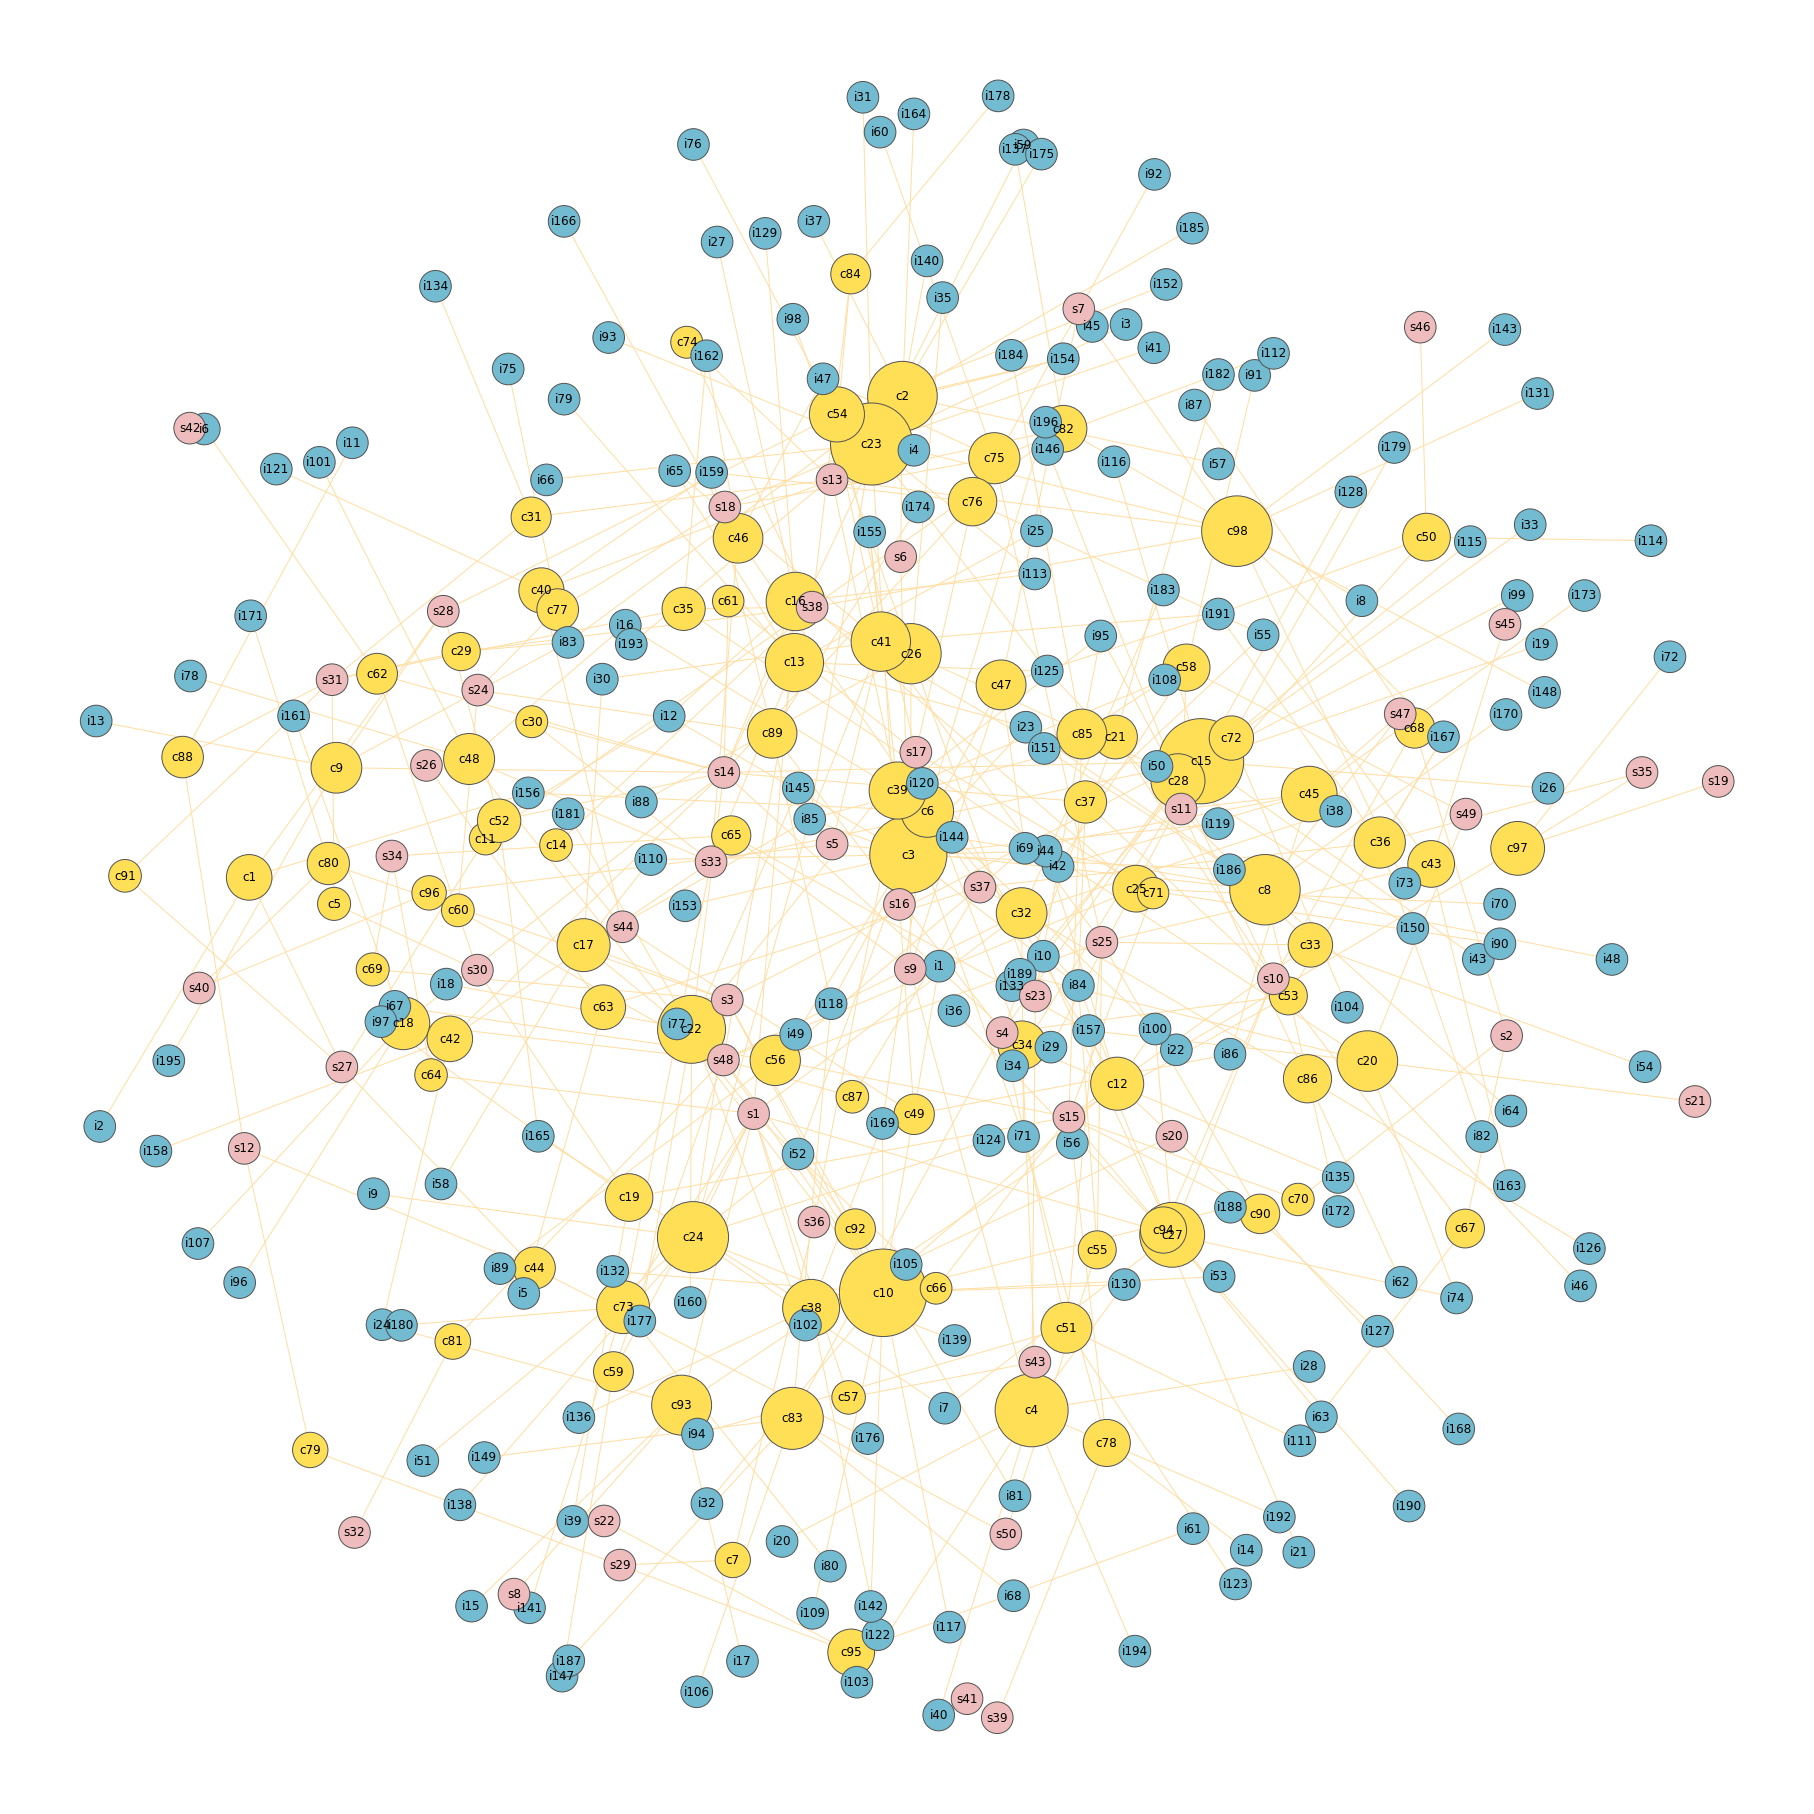

In [52]:
plt.figure(figsize=(25,25))
options = {
    'edge_color': '#FFDEA2',
    'width': 1,
    'with_labels': True,
    'font_weight': 'regular',
}
colors = [color_map[G.nodes[node]['group']] for node in G]
sizes = [G.nodes[node]['nodesize']*10 for node in G]

nx.draw(G, node_color=colors, node_size=sizes, pos=nx.spring_layout(G, k=0.25, iterations=50), **options)
ax = plt.gca()
ax.collections[0].set_edgecolor("#555555") 
plt.show()